In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import random

import mplhep as hep

hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [2]:
hcal_start_z=359.6

class beampipe:
    def holeX(self, layer):
        z=hcal_start_z+layer*2.34
        return -9.923+(z-122.864)*(-11.252+9.923)/(522.664-122.864)
    def holeR(self, layer):
        z=hcal_start_z+layer*2.34
        clearance=3.85
        return clearance+4.403+(z-122.864)*(14.592-4.403)/(522.664-122.864)
beampipe0=beampipe()

In [3]:
def layer_boundaries(layer=0, side="L", beampipe=beampipe0):
    
    holeX=beampipe.holeX(layer)
    holeR=beampipe.holeR(layer)
    if side=="R":
        
        
        phi= np.linspace(-np.pi/2, np.pi/2, 25)
        
        x,y = [-39.8, -39.8, -0.2, -0.2] + list(holeX-holeR*np.cos(phi)) + [-0.2,-0.2, -39.8], \
                 [-29.9,29.9, 29.9, holeR]+ list(-holeR*np.sin(phi))+ [-holeR,-29.9, -29.9]
        return Polygon(zip(x,y))
    if side=="L":
        
        phi0 = np.arccos((holeX-.2)/holeR)
        #print((np.pi-phi0)/np.pi*2)
        phi = np.linspace(phi0,2*np.pi-phi0, 13)
        
        x=[19.8, 19.8, 0.2] + list(holeX-np.cos(phi)*holeR) + [0.2, 19.8]
        y=[-29.9,29.9, 29.9]+list(holeR*np.sin(phi)) + [-29.9, -29.9]
        return Polygon(zip(x,y))

In [40]:
#return a pandas.DataFrame of the cell positions.
#check for the reasonable side lengths
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

def cell_positions(layer, poly,
                   R_readout=0.4, sidelength=1.86, debug=False):
    y0=sidelength/2+min(poly.exterior.xy[1])
    
    nrows = int((max(poly.exterior.xy[1])-min(poly.exterior.xy[1]))/(sidelength*np.sqrt(3)/2)+1)
    
    y0=(max(poly.exterior.xy[1])+min(poly.exterior.xy[1]))/2-sidelength*np.sqrt(3)/2*((nrows-1)//2)
    
    
    ncol= int((max(poly.exterior.xy[0])-min(poly.exterior.xy[0]))/(sidelength*3/2))+2
    x0=min(poly.exterior.xy[0])
    d={a:[] for a in "x y xh yh row col boundsx boundsy area dimpleshift cropped augmented".split()}
    
    
    shiftX=[-sidelength, 0, sidelength][layer%3]
    shiftY=[0, 0, 0][layer%3]
    
    phi=np.linspace(-2*np.pi/3, np.pi, 6)
    for i in range(nrows):
        for j in range(ncol):
            if (i +j) %2!=0:
                continue
            x=x0+j*sidelength*3/2+shiftX
            y=y0+sidelength*np.sqrt(3)/2*i+shiftY
            
            xh=x
            yh=x
            
            xc=x
            yc=y
            
            if not Point(x,y).buffer(R_readout).within(poly):
                found = False
                mindist=0
                # now see if shifting the dimple halfway towards one of the corners will 
                # make it be fully within the detector
                # TODO change this to the centroid.  
                hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
                overlap=poly.intersection(hexagon)
                if overlap.area==0:
                    continue
                centroid=overlap.centroid
                if not centroid.buffer(R_readout).within(poly):
                    continue
                xc,yc = centroid.xy
                #for xc, yc in zip(x+np.cos(phi)*sidelength/2, y+np.sin(phi)*sidelength/2):
                #    p=Point(xc,yc)
                #    dist=p.distance(poly.exterior)
                #    if p.buffer(R_readout).within(poly) and dist>mindist:
                #        found=(xc, yc)
                #        mindist=dist
                #if not found:
                #   continue 
                #else :
                #    xc,yc=found
                d['dimpleshift'].append(1)
            else :
                d['dimpleshift'].append(0)
            d['x'].append(xc)
            d['y'].append(yc)
            
            d['xh'].append(x)
            d['yh'].append(y)
            
            d['row'].append(i)
            d['col'].append(j)
            
            
            hexagon=Polygon(zip(x+sidelength*np.cos(phi),y+sidelength*np.sin(phi)))
            if poly.contains(hexagon):
                cropped = 0
                d['boundsx'].append(hexagon.exterior.xy[0])
                d['boundsy'].append(hexagon.exterior.xy[1])
                d['area'].append(hexagon.area)
            else :
                cropped = 1
                newpoly=poly.intersection(hexagon)
                #print(newpoly.exterior)
                d['boundsx'].append(newpoly.exterior.xy[0])
                d['boundsy'].append(newpoly.exterior.xy[1])
                d['area'].append(newpoly.area)
            #for k in range(6):
            #    if not Point(x+sidelength*np.cos(np.pi*k/3),y+sidelength*np.sin(np.pi*k/3)).within(poly):
            #        full=0
            #        break
            #if not full:
                
            d['cropped'].append(cropped)
            d['augmented'].append(0) # no augmenting at this stage yet.  
    df=pd.DataFrame(d)
    
    #now extend any cells that need extending.  Need to find a better way to do this
    for i in range(len(df)):
        #check if the neighboring cell is a fragment (which is not in the dataframe)
        #.  If so, take a piece of it and add it to the current cell.  
        dc, dr = (1, 1,0, -1, -1,0), (-1, 1,2,1, -1, -2)
        
        for j in range(len(dc)):
            r=df.row[i]+dr[j]
            c=df.col[i]+dc[j]
            if not len(df.query(f'row== {r} and col=={c}')):
                cell=Polygon(zip(df.boundsx[i], df.boundsy[i]))
                #find center of the fragmented 
                x=x0+(df.col[i]+dc[j])*sidelength*3/2+shiftX
                y=y0+sidelength*np.sqrt(3)/2*(df.row[i]+dr[j])+shiftY
                
                corner1 = (x+df.xh[i])/2+(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2-(df.xh[i]-x)/np.sqrt(3)/2
                corner2 = (x+df.xh[i])/2-(df.yh[i]-y)/np.sqrt(3)/2,(y+df.yh[i])/2+(df.xh[i]-x)/np.sqrt(3)/2
                
                
                merge=Polygon([(x,y), corner1, (df.xh[i], df.yh[i]),corner2])
                
                newpoly=unary_union([cell,merge])
                newpoly=poly.intersection(newpoly).simplify(.0001)
                #print(newpoly)
                if not type(newpoly)== Polygon:
                    if debug: print("warning disjointed polygon!", type(newpoly), j)
                    continue
                df.loc[:,"boundsx"][i][:], df.loc[:,"boundsy"][i][:]= newpoly.exterior.xy
                df.loc[i,"area"]=newpoly.area
                #df.loc[:,('boundsx',i)],df.loc[:,('boundsy',i)]=newpoly.exterior.xy
                #df.loc[:,('area',i)]=newpoly.area
                #for k in range(6):
                #if two consecutive neighbors are fragments, merge a larger fraction of both of them into this one
                for dj in 1,:
                    r2=df.row[i]+dr[(j+dj)%6]
                    c2=df.col[i]+dc[(j+dj)%6]
                    if not len(df.query(f'row== {r2} and col=={c2}')):
                        x2=x0+c2*sidelength*3/2+shiftX
                        y2=y0+sidelength*np.sqrt(3)/2*r2+shiftY
                        
                        corner3 = 2*(x+x2)/3-df.xh[i]/3,2*(y+y2)/3-df.yh[i]/3
                        
                        
                        
                        merge=Polygon([(x,y), corner3, (x2,y2), (df.xh[i], df.yh[i])])
                        #print(merge.area)
                        newpoly=unary_union([newpoly,merge])
                        newpoly=poly.intersection(newpoly)
                        #print(newpoly)
                        if not type(newpoly)== Polygon:
                            if debug: print("warning disjointed polygon!","XXXX")
                            continue
                        df.loc[:,"boundsx"][i][:], df.loc[:,"boundsy"][i][:]= newpoly.exterior.xy
                        df.loc[i,"area"]=newpoly.area
                tol=1e-7
                if abs(newpoly.area-cell.area)/cell.area>tol:
                    df.loc[i,"augmented"]=1
                
    if debug: print(f"layer={layer} hex area ={sum(df.area)}, boundary area={poly.area}, ratio= {sum(df.area)/poly.area}")
    return df
            

In [41]:

def draw_layer(layer, R_readout=0.4, sidelength=1.86, fillDimple=True):
    phi = np.linspace(-np.pi, np.pi, 7)
    dx=sidelength*np.cos(phi)
    dy=sidelength*np.sin(phi)
    color='krb'[layer%3]
    for side in "LR":
        boundaries=layer_boundaries(layer, side)
        
        plt.plot(*boundaries.exterior.xy, linestyle='-', color=color)
        df = cell_positions(layer,boundaries, R_readout, sidelength)
        for i in range(len(df)):
            plt.gca().add_patch(mpl.patches.Circle((df.x[i], df.y[i]), R_readout, color=color,
                                                      linestyle='' if fillDimple else '-',
                                                    fill=fillDimple))
            
            plt.plot(df.boundsx[i], df.boundsy[i], color=color)
                #plt.plot(df.x[i]+dx, df.y[i]+dy, color=color)
    

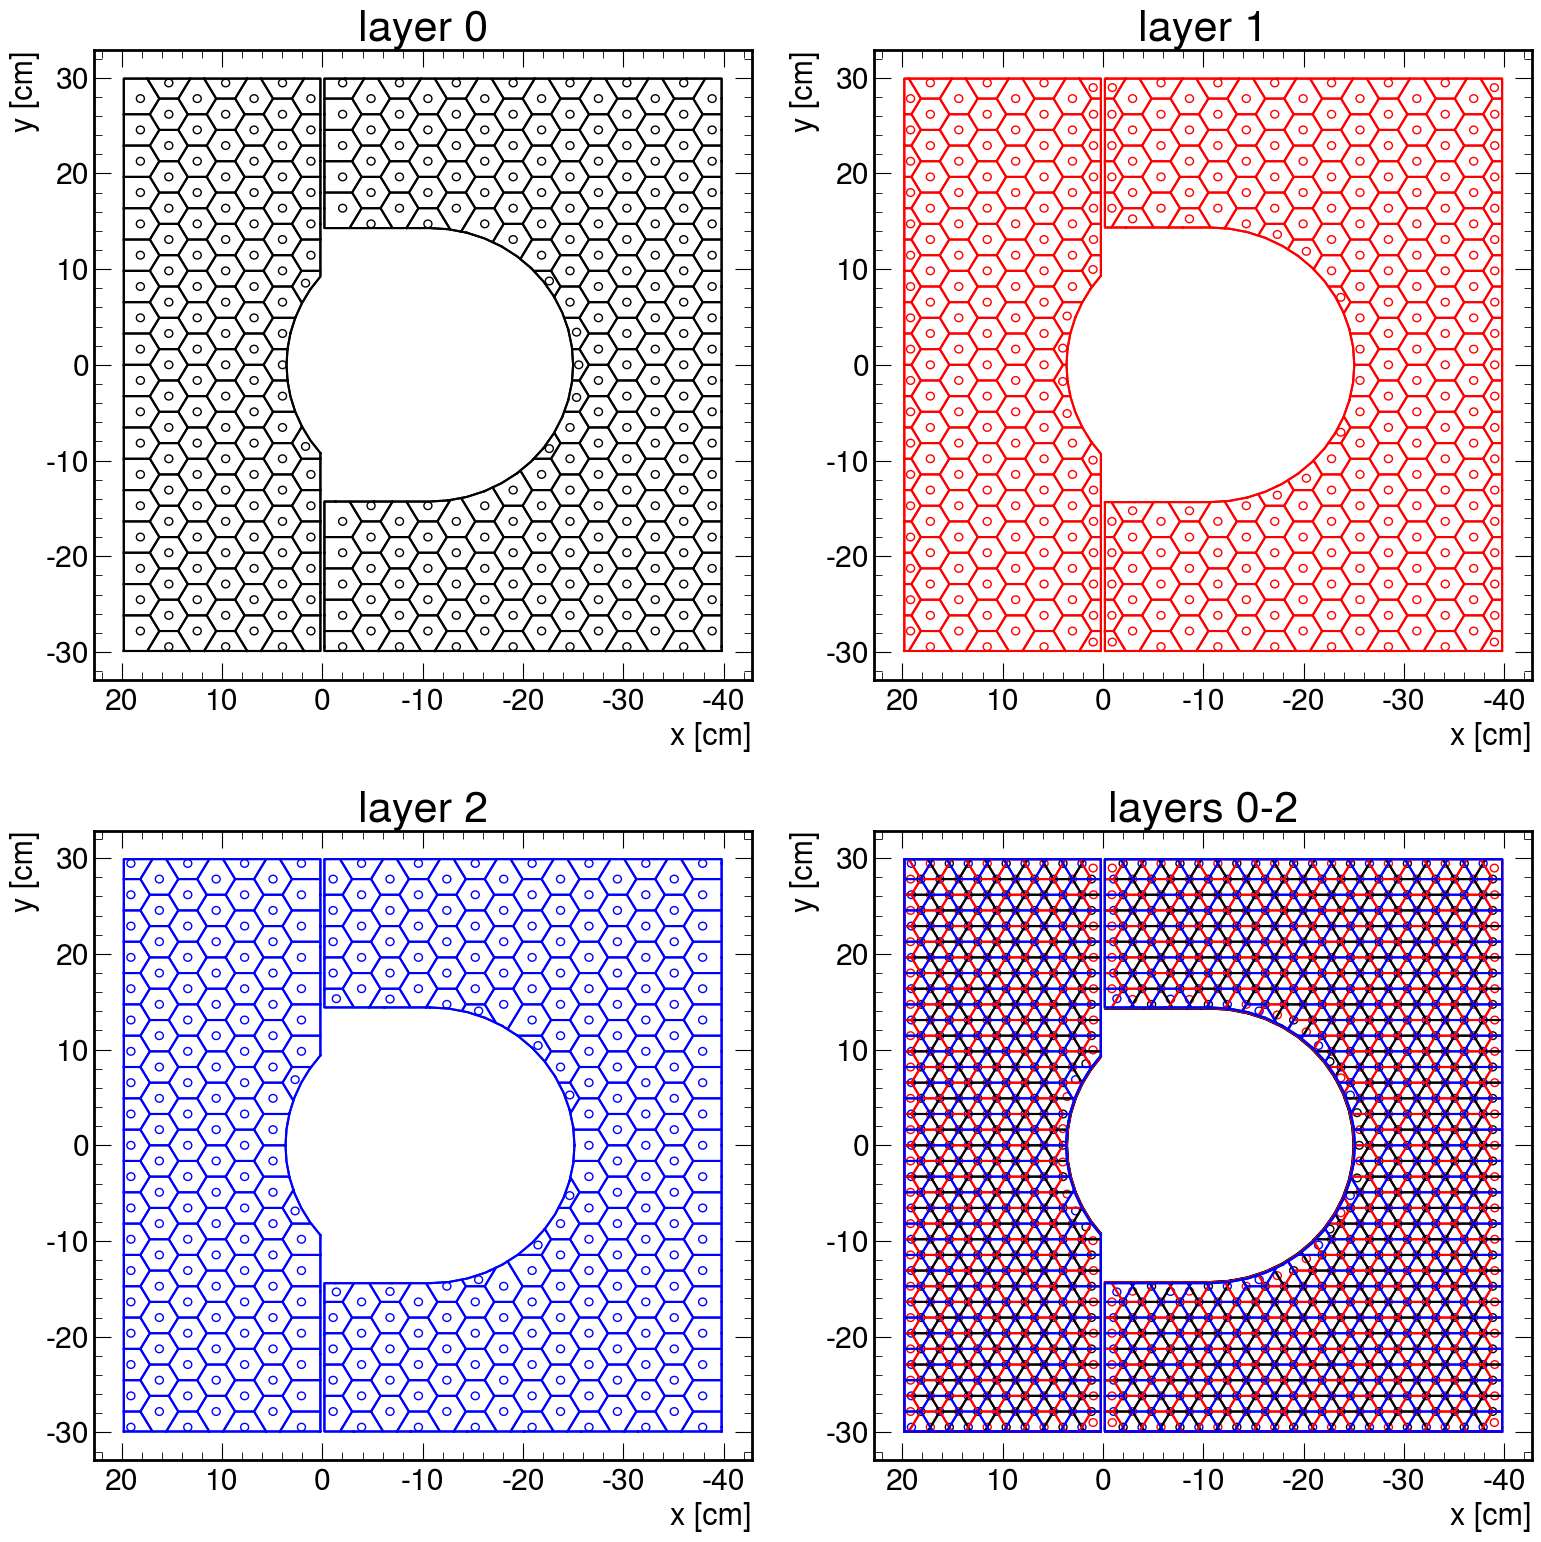

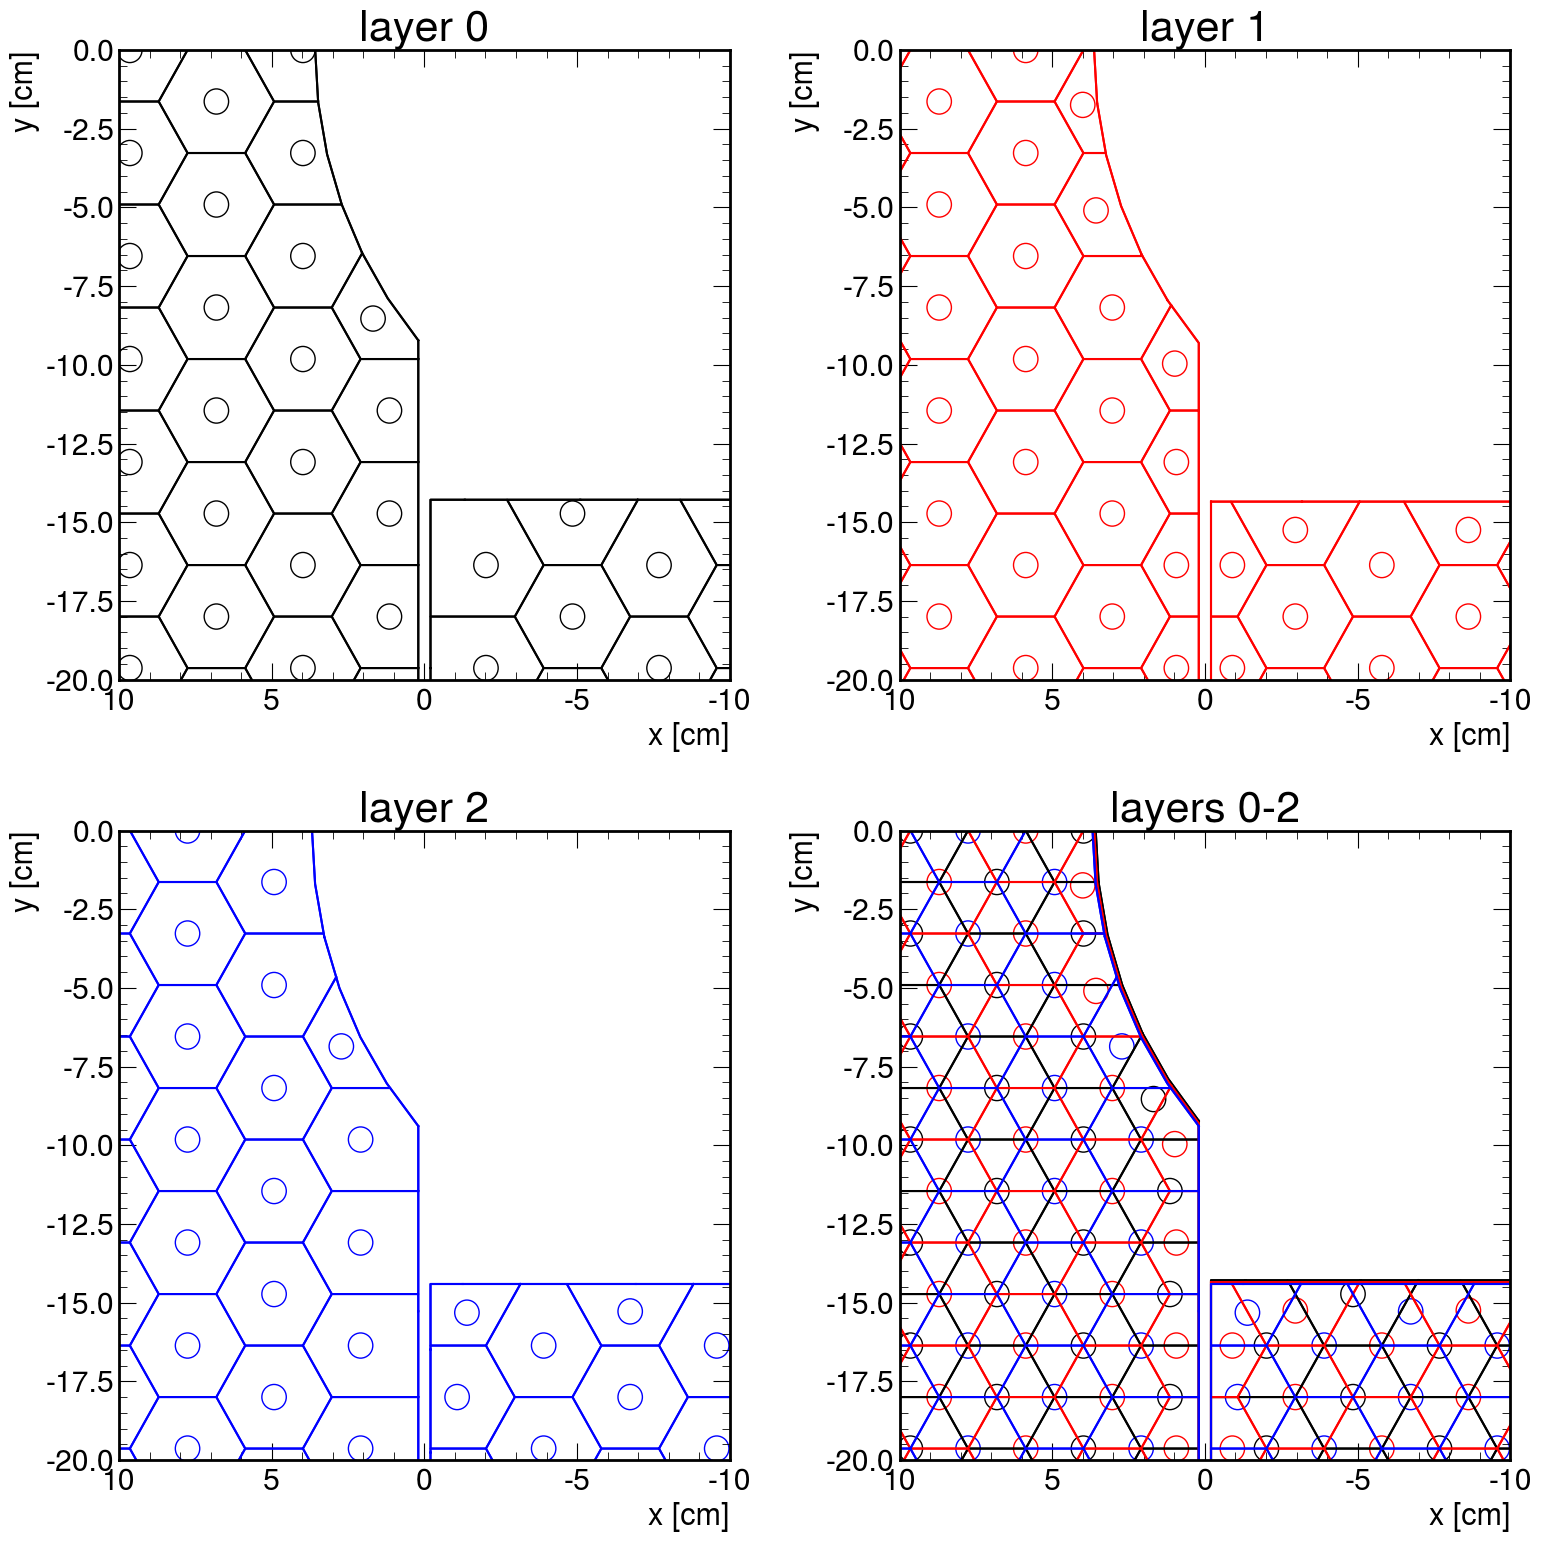

In [46]:
#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)

for zoom in False, True:
    arg=dict(fillDimple=False, sidelength=sidelength)
    fig,axs=plt.subplots(2,2, figsize=(16,16))
    for i in range(3):

        plt.sca(axs[i//2][i%2])
        plt.title(f"layer {i}")
        draw_layer(i, **arg)
        plt.gca().invert_xaxis()
        plt.sca(axs[1][1])
        plt.title(f"layers 0-2")
        draw_layer(i, **arg)
    axs[1][1].invert_xaxis()
    for row in axs:
        for ax in row:
            ax.set_xlabel("x [cm]", fontsize=22)
            ax.set_ylabel("y [cm]", fontsize=22)
            if zoom:
                ax.set_xlim(-10, 10)
                ax.set_ylim(-20, 0)
                ax.invert_xaxis()
    plt.tight_layout()
    plt.savefig(f"Layers_0-2{'_zoom' if zoom else ''}.pdf")
    plt.show()

In [47]:
def print_summary_stats(df):
    hexagons=df.query("augmented==0 and cropped==0")
    tot_area=sum(df.area)
    hex_area=sum(hexagons.area)
    
    n_tot = len(df)
    n_hex = len(hexagons)
    print(f"total area: {tot_area:.1f} cm^2")
    print(f"regular hexagon area: {hex_area:.1f} cm^2")
    print(f"(regular hexagon area)/(total area): {100*hex_area/tot_area:.1f}%")
    print(f"total cells: {n_tot}")
    print(f"regular hexagon cells: {n_hex}")
    print(f"(regular hexagon cells)/(total cells): {100*n_hex/n_tot:.1f}%")

In [48]:


def write_for_openscad(df, file=None):
    segments=[]
    print("segments=[", file=file)
    lines=[]
    for i in range(len(df)):
        for j in range(len(df.boundsx[i])-1):
            segment = {(df.boundsx[i][j], df.boundsy[i][j]), (df.boundsx[i][j+1], df.boundsy[i][j+1])}
            
            if segment not in segments:
                lines.append(f"[[{10*df.boundsx[i][j]:.3f},{10*df.boundsy[i][j]:.3f}], [{10*df.boundsx[i][j+1]:.3f}, {10*df.boundsy[i][j+1]:.3f}]]")
                segments.append(segment)
        #print()
    print(",\n".join(lines), file=file)
    print("];", file=file)

#now test this
layer=0
side="L"

#use sidelength from the model used in the JINST paper
sidelength=1.843
#increase sidelength to account for a wider space between cells
sidelength+=0.04/(np.sqrt(3)/2)

bounds=layer_boundaries(layer, side)
df=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength)

with open("openscad/segments.scad", "w") as f:
    write_for_openscad(df, file=f)

In [31]:
sidelength=1.843
layer=0
side="R"
bounds=layer_boundaries(layer, side)
#use sidelength from the model used in the JINST paper
df_right=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength)


layer=0
side="L"    
bounds=layer_boundaries(layer, side)
#use sidelength from the model used in the JINST paper
df_left=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelength)
print("layer 0, left")
print_summary_stats(df_left)
print()
print("layer 0, right")
print_summary_stats(df_right)

layer 0, left
total area: 1129.8 cm^2
regular hexagon area: 688.3 cm^2
(regular hexagon area)/(total area): 60.9%
total cells: 125
regular hexagon cells: 78
(regular hexagon cells)/(total cells): 62.4%

layer 0, right
total area: 1748.1 cm^2
regular hexagon area: 1094.3 cm^2
(regular hexagon area)/(total area): 62.6%
total cells: 197
regular hexagon cells: 124
(regular hexagon cells)/(total cells): 62.9%


In [8]:
#now tabulate all layers.  
all_layers ={}
sidelengths=[1.843]*9+[3.102]*9 + [3.722]*42
for layer in range(60):
    for side in "LR":
        bounds=layer_boundaries(layer, side)
        all_layers[(layer, side)]=cell_positions(layer, bounds,
                   R_readout=0.4, sidelength=sidelengths[layer])

/opt/homebrew/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [11]:
for layer, side in all_layers:
    with open(f"openscad/boundaries_{layer}_{side}.scad", "w") as f:
        write_for_openscad(all_layers[(layer,side)], file=f)

In [9]:
# If we want the height of the detector to be a multiple of one row height, or s*sqrt(3)/2
# then s should be h_det/(N*sqrt(3)/2) for an integer N.  
# Not sure this is necessary though

#determine a table of possible sizes based on this:
htot=59.8
d={key:[] for key in "nrows s A sqrtA ".split()}
for nrows in range(30, 50):
    s=htot/(np.sqrt(3)/2)/nrows
    A=s*s*3*np.sqrt(3)/2
    d['nrows'].append(nrows)
    d['s'].append(s)
    d['A'].append(A)
    d['sqrtA'].append(np.sqrt(A))
df=pd.DataFrame(d)
print(df)

    nrows         s          A     sqrtA
0      30  2.301703  13.764184  3.710011
1      31  2.227455  12.890495  3.590334
2      32  2.157847  12.097428  3.478136
3      33  2.092457  11.375359  3.372738
4      34  2.030914  10.716061  3.273539
5      35  1.972888  10.112462  3.180010
6      36  1.918086   9.558461  3.091676
7      37  1.866246   9.048770  3.008117
8      38  1.817134   8.578785  2.928956
9      39  1.770541   8.144488  2.853855
10     40  1.726277   7.742354  2.782509
11     41  1.684173   7.369284  2.714642
12     42  1.644074   7.022543  2.650008
13     43  1.605839   6.699711  2.588380
14     44  1.569343   6.398639  2.529553
15     45  1.534469   6.117415  2.473341
16     46  1.501111   5.854332  2.419573
17     47  1.469172   5.607861  2.368092
18     48  1.438564   5.376635  2.318757
19     49  1.409206   5.159419  2.271436


In [569]:
np.sqrt(25/(3*np.sqrt(3)/2))
np.sqrt(36/(3*np.sqrt(3)/2))

3.7224194364083982